## Set up

In [1]:
!pip install pysaliency --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.3 MB/s eta 0:00:00


In [29]:
import os
import time
import copy
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import cv2
from PIL import Image
import torch.nn.functional as F
from os.path import join as pjoin
import logging
import math

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage
from typing import Type, Any, Callable, Union, List, Optional
import pysaliency
from pysaliency.baseline_utils import BaselineModel, CrossvalidatedBaselineModel
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset

In [3]:
# Mount the notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Unzip the data into the data foler in colab
# Might need to change this, My zipped data was in the Colab Notebooks folder
!mkdir '/content/data'
!unzip -qo '/content/drive/MyDrive/Visual Attention System - Project/Datasets/Salicon.zip' -d  '/content/data'

In [5]:
# Create directories for the train and validation images and annotations
DATA_DIR = '/content/data/Salicon'
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR,"images", 'train')
TRAIN_ANNOT_DIR = os.path.join(DATA_DIR, "annotations", "train")
VALID_IMAGE_DIR = os.path.join(DATA_DIR, "images", "test")
VALID_ANNOT_DIR = os.path.join(DATA_DIR, "annotations", 'val')
TEST_IMAGE_DIR = os.path.join(DATA_DIR,"images", 'val')

In [6]:
# Transforms for the train images and annotations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annot_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
def ensure_color_image(image):
    if len(image.shape) == 2:
        return np.dstack([image, image, image])
    return image

In [8]:
# Dataset class
from scipy.ndimage import zoom
from scipy.special import logsumexp

class MyDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None, annot_transforms =None, train=True):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.annot_transforms = annot_transforms
        self.train = train

        # This line of code returns a sorted list of full paths to each image in the directory
        self.img_paths = list(map(lambda fname: os.path.join(self.image_dir, fname), sorted(os.listdir(self.image_dir))))

        # Annotated images
        self.annotation_paths = list(map(lambda fname: os.path.join(self.annotation_dir, fname), sorted(os.listdir(self.annotation_dir))))

        # Load the center bias template calculated using the MIT1003 dataset
        centerbias_template = np.load("/content/drive/MyDrive/Visual Attention System - Project/Datasets/centerbias_mit1003.npy")
        # 480, 640

        # The size of the center bias changes depending on the size of the image. For each image we have to change this value torch_image.shape[1]
        self.centerbias = zoom(centerbias_template, (480/centerbias_template.shape[0], 640/centerbias_template.shape[1]), order=0, mode='nearest')
        # renormalize log density
        self.centerbias -= logsumexp(self.centerbias)
        # image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
        # centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if self.train:
            # image = self.img_paths[idx]
            if self.annot_transforms(Image.open(self.img_paths[idx])).shape[0] ==1:
                # self.img_paths[idx] = torch.stack((image, image, image), dim=0).squeeze()
                image = self.annot_transforms(Image.open(self.img_paths[idx]))
                return torch.stack((image, image, image),dim=0).squeeze(), self.annot_transforms(Image.open(self.annotation_paths[idx])), self.annot_transforms(self.centerbias)
        return self.transforms(Image.open(self.img_paths[idx])), self.annot_transforms(Image.open(self.annotation_paths[idx])), self.annot_transforms(self.centerbias)

In [9]:
transform = transforms.ToTensor()
images = transform(Image.open("/content/data/Salicon/annotations/val/COCO_val2014_000000000133.png"))
images.shape

torch.Size([1, 480, 640])

In [10]:
image = torch.randn((1,32, 32))
images = torch.stack((image, image, image), dim=0).squeeze()
images.shape

torch.Size([3, 32, 32])

In [11]:
# Dataloader 
train_dataset = MyDataset(TRAIN_IMAGE_DIR,TRAIN_ANNOT_DIR,train_transforms, annot_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, drop_last =False, num_workers =2)

In [33]:
input_image, saliency_map, center_bias = next(iter(train_loader))
print(f"input image shape: {input_image.shape}")
print(f"saliency map shape: {saliency_map.shape}")
print(f"center bias shape: {center_bias.shape}")

input image shape: torch.Size([32, 3, 480, 640])
saliency map shape: torch.Size([32, 1, 480, 640])
center bias shape: torch.Size([32, 1, 480, 640])


In [12]:
valid_dataset = MyDataset(VALID_IMAGE_DIR, VALID_ANNOT_DIR, train_transforms, annot_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=32, drop_last =False, num_workers=2)

In [13]:
# Print the length of the dataloader
print("Train batches: ", train_loader.__len__())

Train batches:  313


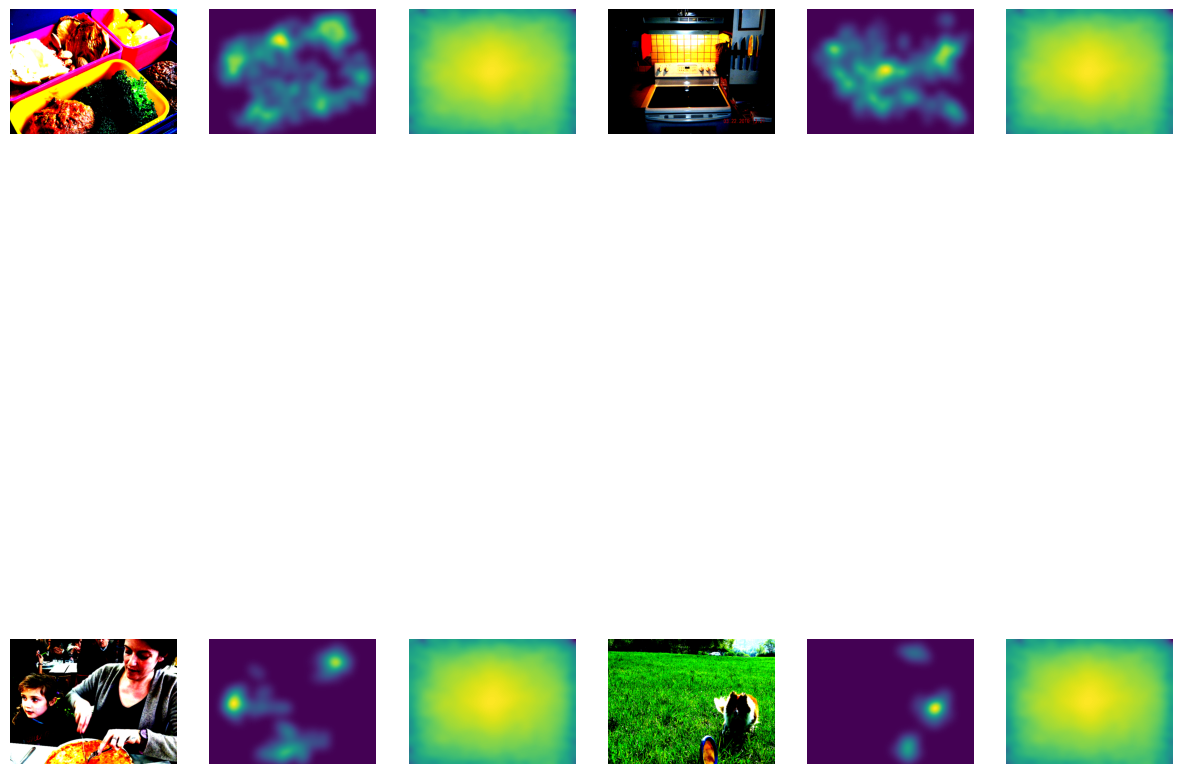

In [14]:
# Display some of the images in the dataset together with their annotations
r, c = [2,6]
fig, ax = plt.subplots(r, c, figsize = (15, 15)) 

k = 0

for data in train_loader:
    x, y, z = data

    # print(x.shape)

    for i in range(r):
        for j in range(0,c,3):
            img = x[k].numpy().transpose(1,2,0)
            ann = y[k].numpy().transpose(1,2,0)
            gauss = z[k].numpy().transpose(1,2,0)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            ax[i, j+1].imshow(ann)
            ax[i, j+1].axis("off")
            ax[i, j+2].imshow(gauss)
            ax[i, j+2].axis("off")
            k +=1
    break        
     

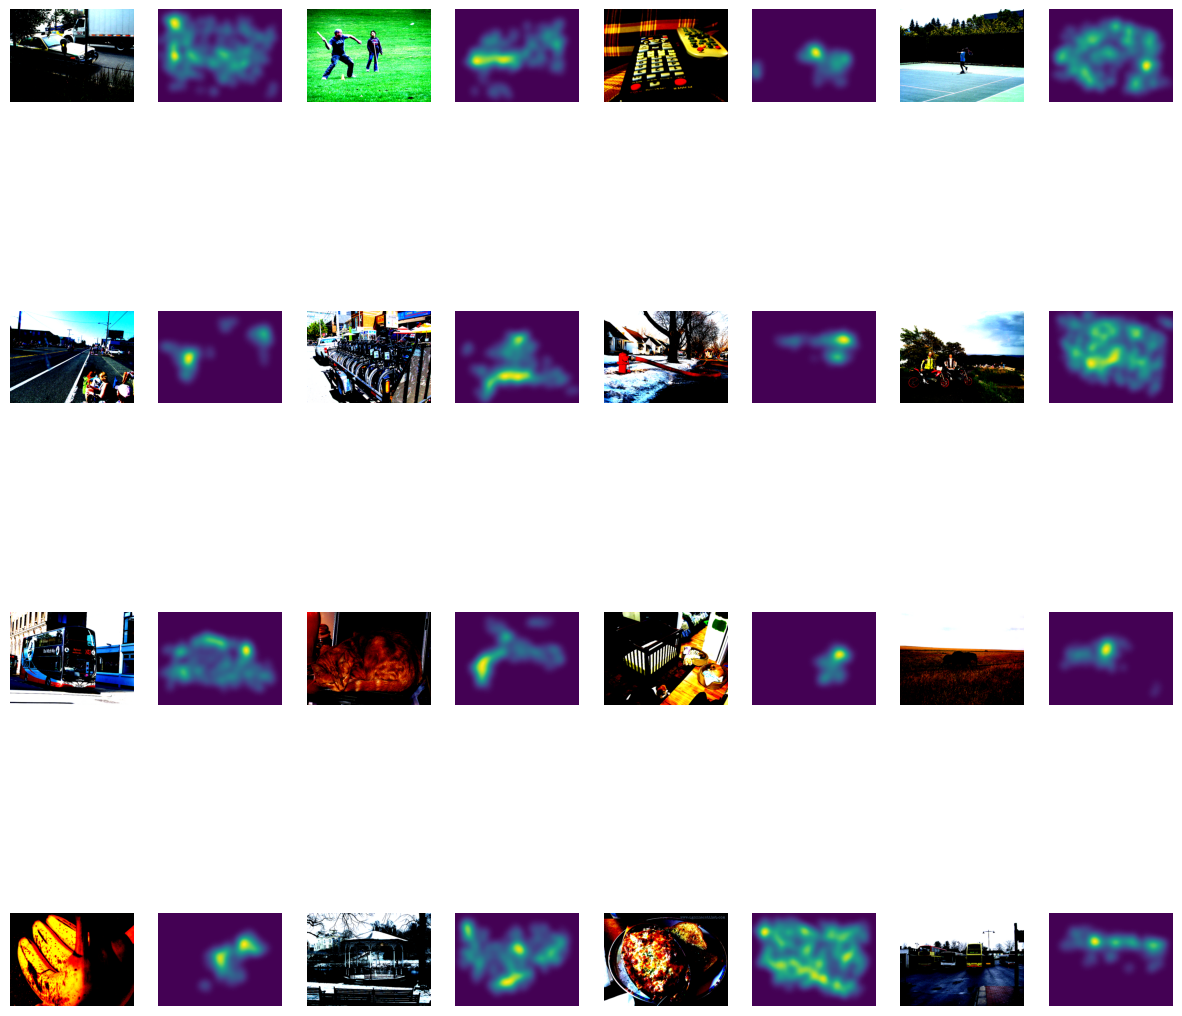

In [15]:
# Display some of the images in the dataset together with their annotations
r, c = [4,8]
fig, ax = plt.subplots(r, c, figsize = (15, 15))

k = 0

for data in valid_loader:
    x, y, z = data

    # print(x.shape)

    for i in range(r):
        for j in range(0,c,2):
            img = x[k].numpy().transpose(1,2,0)
            ann = y[k].numpy().transpose(1,2,0)
            ax[i, j].imshow(img)
            ax[i, j].axis("off")
            ax[i, j+1].imshow(ann)
            ax[i, j+1].axis("off")
            k +=1
    break
     

## Utils

In [16]:
class SaliencyLoss(nn.Module):
    def __init__(self):
        super(SaliencyLoss, self).__init__()

    def forward(self, preds, labels, loss_type='cc'):
        losses = []
        if loss_type == 'cc':
            for i in range(labels.shape[0]): # labels.shape[0] is batch size
                loss = loss_CC(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'kldiv':
            for i in range(labels.shape[0]):
                loss = loss_KLdiv(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'sim':
            for i in range(labels.shape[0]):
                loss = loss_similarity(preds[i],labels[i])
                losses.append(loss)

        elif loss_type == 'nss':
            for i in range(labels.shape[0]):
                loss = loss_NSS(preds[i],labels[i])
                losses.append(loss)
            
        return torch.stack(losses).mean(dim=0, keepdim=True)
        
        
def loss_KLdiv(pred_map, gt_map):
    eps = 2.2204e-16
    pred_map = pred_map/torch.sum(pred_map)
    gt_map = gt_map/torch.sum(gt_map)
    div = torch.sum(torch.mul(gt_map, torch.log(eps + torch.div(gt_map,pred_map+eps))))
    return div 
        
    
def loss_CC(pred_map,gt_map):
    gt_map_ = (gt_map - torch.mean(gt_map))
    pred_map_ = (pred_map - torch.mean(pred_map))
    cc = torch.sum(torch.mul(gt_map_,pred_map_))/torch.sqrt(torch.sum(torch.mul(gt_map_,gt_map_))*torch.sum(torch.mul(pred_map_,pred_map_)))
    return cc


def loss_similarity(pred_map,gt_map):
    gt_map = (gt_map - torch.min(gt_map))/(torch.max(gt_map)-torch.min(gt_map))
    gt_map = gt_map/torch.sum(gt_map)
    
    pred_map = (pred_map - torch.min(pred_map))/(torch.max(pred_map)-torch.min(pred_map))
    pred_map = pred_map/torch.sum(pred_map)
    
    diff = torch.min(gt_map,pred_map)
    score = torch.sum(diff)
    
    return score
    
    
def loss_NSS(pred_map,fix_map):
    '''ground truth here is fixation map'''

    pred_map_ = (pred_map - torch.mean(pred_map))/torch.std(pred_map)
    mask = fix_map.gt(0)
    score = torch.mean(torch.masked_select(pred_map_, mask))
    return score

In [61]:
# ResNet from PyTorchVision
from torchvision.models import resnet50, ResNet50_Weights

resnet_from_torch = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet_from_torch

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
summary(resnet_from_torch.to(device), (3, 384, 288))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 144]           9,408
       BatchNorm2d-2         [-1, 64, 192, 144]             128
              ReLU-3         [-1, 64, 192, 144]               0
         MaxPool2d-4           [-1, 64, 96, 72]               0
            Conv2d-5           [-1, 64, 96, 72]           4,096
       BatchNorm2d-6           [-1, 64, 96, 72]             128
              ReLU-7           [-1, 64, 96, 72]               0
            Conv2d-8           [-1, 64, 96, 72]          36,864
       BatchNorm2d-9           [-1, 64, 96, 72]             128
             ReLU-10           [-1, 64, 96, 72]               0
           Conv2d-11          [-1, 256, 96, 72]          16,384
      BatchNorm2d-12          [-1, 256, 96, 72]             512
           Conv2d-13          [-1, 256, 96, 72]          16,384
      BatchNorm2d-14          [-1, 256,

In [70]:
r = resnet50(pretrained=False)
r
summary(r.cuda(), (3, 384, 288))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 144]           9,408
       BatchNorm2d-2         [-1, 64, 192, 144]             128
              ReLU-3         [-1, 64, 192, 144]               0
         MaxPool2d-4           [-1, 64, 96, 72]               0
            Conv2d-5           [-1, 64, 96, 72]           4,096
       BatchNorm2d-6           [-1, 64, 96, 72]             128
              ReLU-7           [-1, 64, 96, 72]               0
            Conv2d-8           [-1, 64, 96, 72]          36,864
       BatchNorm2d-9           [-1, 64, 96, 72]             128
             ReLU-10           [-1, 64, 96, 72]               0
           Conv2d-11          [-1, 256, 96, 72]          16,384
      BatchNorm2d-12          [-1, 256, 96, 72]             512
           Conv2d-13          [-1, 256, 96, 72]          16,384
      BatchNorm2d-14          [-1, 256,

In [44]:
from typing import Type, Any, Callable, Union, List, Optional

import torch
import torch.nn as nn
from torch import Tensor

# from .._internally_replaced_utils import load_state_dict_from_url
# from ..utils import _log_api_usage_once


__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-f37072fd.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-b627a593.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-0676ba61.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-63fe2227.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-394f9c45.pth",
    "resnext50_32x4d": "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
    "resnext101_32x8d": "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth",
    "wide_resnet50_2": "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth",
    "wide_resnet101_2": "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth",
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        if arch == 'resnet50':
            state_dict = torch.load(r'pretrained_models/resnet50-0676ba61.pth')
        else:
            state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet101", Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet152", Bottleneck, [3, 8, 36, 3], pretrained, progress, **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["groups"] = 32
    kwargs["width_per_group"] = 4
    return _resnet("resnext50_32x4d", Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["groups"] = 32
    kwargs["width_per_group"] = 8
    return _resnet("resnext101_32x8d", Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["width_per_group"] = 64 * 2
    return _resnet("wide_resnet50_2", Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs["width_per_group"] = 64 * 2
    return _resnet("wide_resnet101_2", Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)

## Trans based on DenseNet

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu}

class Attention(nn.Module):
    def __init__(self, config):
        super(Attention, self).__init__()
        self.num_attention_heads = config["num_heads"]  # 12
        self.attention_head_size = int(config['hidden_size'] / self.num_attention_heads)    # 42
        self.all_head_size = self.num_attention_heads * self.attention_head_size    # 12*42=504

        self.query = Linear(config['hidden_size'], self.all_head_size)  # (512, 504)
        self.key = Linear(config['hidden_size'], self.all_head_size)
        self.value = Linear(config['hidden_size'], self.all_head_size)

        # self.out = Linear(config['hidden_size'], config['hidden_size'])
        self.out = Linear(self.all_head_size, config['hidden_size'])
        self.attn_dropout = Dropout(config["attention_dropout_rate"])
        self.proj_dropout = Dropout(config["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):

        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output

class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config['hidden_size'], config["mlp_dim"])
        self.fc2 = Linear(config["mlp_dim"], config['hidden_size'])
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config["dropout_rate"])
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.flag = config['num_heads']
        self.hidden_size = config['hidden_size']
        self.ffn_norm = LayerNorm(config['hidden_size'], eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config)
        self.attention_norm = LayerNorm(config['hidden_size'], eps=1e-6)

    def forward(self, x):
        h = x

        x = self.attention_norm(x)
        x = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x


class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()

        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config['hidden_size'], eps=1e-6)
        for _ in range(config["num_layers"]):
            layer = Block(config)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        for layer_block in self.layer:
            hidden_states = layer_block(hidden_states)
        encoded = self.encoder_norm(hidden_states)

        return encoded

In [62]:
# Configs

cfg1 = {
"hidden_size" : 768,
"mlp_dim" : 768*4,
"num_heads" : 12,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}

cfg2 = {
"hidden_size" : 768,
"mlp_dim" : 768*4,
"num_heads" : 12,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}

cfg3 = {
"hidden_size" : 512,
"mlp_dim" : 512*4,
"num_heads" : 8,
"num_layers" : 2,
"attention_dropout_rate" : 0,
"dropout_rate" : 0.0,
}


class TranSalNet(nn.Module):

    def __init__(self):
        super(TranSalNet, self).__init__()
        self.encoder = _Encoder()
        self.decoder = _Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class _Encoder(nn.Module):
    def __init__(self):
        super(_Encoder, self).__init__()
        base_model = resnet50(pretrained=False)
        for param in base_model.parameters():
          param.requires_grad = False
        base_layers = list(base_model.children())[:8]
        self.encoder = nn.ModuleList(base_layers).eval()

    def forward(self, x):
        outputs = []
        for ii,layer in enumerate(self.encoder):
            x = layer(x)
            if ii in {5,6,7}:
                outputs.append(x)
        return outputs

class _Decoder(nn.Module):

    def __init__(self):
        super(_Decoder, self).__init__()
        self.conv1 = nn.Conv2d(768, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(768, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv5 = nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv7 = nn.Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.batchnorm1 = nn.BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm4 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm5 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batchnorm6 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.TransEncoder1 = TransEncoder(in_channels=2048, spatial_size=9*12, cfg=cfg1)
        self.TransEncoder2 = TransEncoder(in_channels=1024, spatial_size=18*24, cfg=cfg2)
        self.TransEncoder3 = TransEncoder(in_channels=512, spatial_size=36*48, cfg=cfg3)

        self.add = torch.add
        self.relu = nn.ReLU(True)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x3, x4, x5 = x

        x5 = self.TransEncoder1(x5)
        x5 = self.conv1(x5)
        x5 = self.batchnorm1(x5)
        x5 = self.relu(x5)
        x5 = self.upsample(x5)

        x4_a = self.TransEncoder2(x4)
        x4 = x5 * x4_a
        x4 = self.relu(x4)
        x4 = self.conv2(x4)
        x4 = self.batchnorm2(x4)
        x4 = self.relu(x4)
        x4 = self.upsample(x4)

        x3_a = self.TransEncoder3(x3)
        x3 = x4 * x3_a
        x3 = self.relu(x3)
        x3 = self.conv3(x3)
        x3 = self.batchnorm3(x3)
        x3 = self.relu(x3)
        x3 = self.upsample(x3)

        x2 = self.conv4(x3)
        x2 = self.batchnorm4(x2)
        x2 = self.relu(x2)
        x2 = self.upsample(x2)
        x2 = self.conv5(x2)
        x2 = self.batchnorm5(x2)
        x2 = self.relu(x2)

        x1 = self.upsample(x2)
        x1 = self.conv6(x1)
        x1 = self.batchnorm6(x1)
        x1 = self.relu(x1)
        x1 = self.conv7(x1)
        x = self.sigmoid(x1)

        return x


class TransEncoder(nn.Module):

    def __init__(self, in_channels, spatial_size, cfg):
        super(TransEncoder, self).__init__()

        self.patch_embeddings = nn.Conv2d(in_channels=in_channels,
                                          out_channels=cfg['hidden_size'],
                                          kernel_size=1,
                                          stride=1)
        self.position_embeddings = nn.Parameter(torch.zeros(1, spatial_size, cfg['hidden_size']))

        self.transformer_encoder = Encoder(cfg)

    def forward(self, x):
        a, b = x.shape[2], x.shape[3]
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)

        embeddings = x + self.position_embeddings
        x = self.transformer_encoder(embeddings)
        B, n_patch, hidden = x.shape
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, a, b)

        return x

In [63]:
model =  TranSalNet()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [64]:
model

TranSalNet(
  (encoder): _Encoder(
    (encoder): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
      

In [65]:
summary(model.cuda(), (1,3, 384, 288))

RuntimeError: ignored

## Train

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TranSalNet()
model = model.to(device)
dataset_size = 20

In [54]:
from pysaliency.roc import general_roc
from pysaliency.numba_utils import auc_for_one_positive

def _general_auc(positives, negatives):
    if len(positives) == 1:
        return auc_for_one_positive(positives[0], negatives)
    else:
        return general_roc(positives, negatives)[0]

def log_likelihood(log_density, fixation_mask, weights=None):
    if weights is None:
       weights = torch.ones(log_density.shape[0])

    weights = len(weights) * weights.view(-1, 1, 1) / weights.sum()

    if isinstance(fixation_mask, torch.sparse.IntTensor):
        dense_mask = fixation_mask.to_dense()
    else:
        dense_mask = fixation_mask
    fixation_count = dense_mask.sum(dim=(-1, -2), keepdim=True)
    # print(log_density.shape)
    # print(dense_mask.shape)
    ll = torch.mean(
        weights * torch.sum(log_density * dense_mask, dim=(-1, -2), keepdim=True) / fixation_count
    )
    return (ll + np.log(log_density.shape[-1] * log_density.shape[-2])) / np.log(2)



def nss(log_density, fixation_mask, weights=None):
    weights = len(weights) * weights.view(-1, 1, 1) / weights.sum()
    if isinstance(fixation_mask, torch.sparse.IntTensor):
        dense_mask = fixation_mask.to_dense()
    else:
        dense_mask = fixation_mask

    fixation_count = dense_mask.sum(dim=(-1, -2), keepdim=True)

    density = torch.exp(log_density)
    mean, std = torch.std_mean(density, dim=(-1, -2), keepdim=True)
    saliency_map = (density - mean) / std

    nss = torch.mean(
        weights * torch.sum(saliency_map * dense_mask, dim=(-1, -2), keepdim=True) / fixation_count
    )
    return nss
     
def auc(log_density, fixation_mask, weights=None):
    weights = len(weights) * weights / weights.sum()

    # TODO: This doesn't account for multiple fixations in the same location!
    def image_auc(log_density, fixation_mask):
        if isinstance(fixation_mask, torch.sparse.IntTensor):
            dense_mask = fixation_mask.to_dense()
        else:
            dense_mask = fixation_mask

        positives = torch.masked_select(log_density, dense_mask.type(torch.bool)).detach().cpu().numpy().astype(np.float64)
        negatives = log_density.flatten().detach().cpu().numpy().astype(np.float64)

        auc = _general_auc(positives, negatives)

        return torch.tensor(auc)

    return torch.mean(weights.cpu() * torch.tensor([
        image_auc(log_density[i], fixation_mask[i]) for i in range(log_density.shape[0])
    ]))
     

In [55]:
optimizer = optim.Adam(model.parameters(),lr=1e-5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_fn = torch.nn.BCELoss()

In [56]:
def train_epoch(model, dataset, optimizer, device):
    model.train()
    losses = []
    batch_weights = []
    pbar = tqdm(dataset)
    for batch in pbar:
        optimizer.zero_grad()
        x, y, z = batch
        image = x.to(device)
        fixation = y.to(device)
        gauss = z.mean(dim=0).to(device)
        weights = torch.ones(x.shape[0]).to(device)
        
        log_density = model(image)
        # print("Train loop",log_density.shape)

        loss = -log_likelihood(log_density, fixation, weights=weights)
        losses.append(loss.detach().cpu().numpy())

        batch_weights.append(weights.detach().cpu().numpy().sum())

        pbar.set_description('{:.05f}'.format(np.average(losses, weights=batch_weights)))

        loss.backward()

        optimizer.step()

    return np.average(losses, weights=batch_weights)

In [57]:
loss = train_epoch(model, train_loader, optimizer, device)
loss

  0%|          | 0/313 [00:03<?, ?it/s]


RuntimeError: ignored

In [ ]:
def eval_epoch(model, dataset, device, metrics= None):
    model.eval()
    if metrics is None:
        metrics = ['LL', 'NSS', 'AUC'] # 'IG',

    metric_scores = {}
    metric_functions = {
    'LL': log_likelihood,
    'NSS': nss,
    'AUC': auc,
    }
    batch_weights = []

    with torch.no_grad():
        pbar = tqdm(dataset)
        for batch in pbar:
            optimizer.zero_grad()
            x, y, z = batch
            image = x.to(device)
            fixation = y.to(device)
            centerbias = z.mean(dim=0).to(device)
            weights = torch.ones(x.shape[0]).to(device)
            
            log_density = model(image, centerbias)

            for metric_name, metric_fn in metric_functions.items():
                if metric_name not in metrics:
                    continue
                metric_scores.setdefault(metric_name, []).append(metric_fn(log_density, fixation, weights=weights).detach().cpu().numpy())
            batch_weights.append(weights.detach().cpu().numpy().sum())

            for display_metric in ['LL', 'NSS', 'AUC']:
                if display_metric in metrics:
                    pbar.set_description('{} {:.05f}'.format(display_metric, np.average(metric_scores[display_metric], weights=batch_weights)))
                    break

    data = {metric_name: np.average(scores, weights=batch_weights) for metric_name, scores in metric_scores.items()}

    return data

In [ ]:
data = eval_epoch(deepgaze_res101, valid_loader, device)
data